# Testing clustering with the Loureiro Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('..')
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import re
import time
import math
from scripts.clustering_utils import select_past_timesteps

/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
df = pd.read_csv("../../data/loureiro_40casas.csv")
n_houses = df.shape[1] - 1
df.Time = pd.to_datetime(df.Time)
df

,Time,Energy_1,Energy_2,Energy_9,Energy_15,Energy_16,Energy_17,Energy_30,Energy_35,Energy_48,...,Energy_138,Energy_139,Energy_142,Energy_146,Energy_148,Energy_151,Energy_159,Energy_160,Energy_161,Energy_164
0,2022-05-05 12:00:00,0.068,0.018,0.024,0.164,0.072,0.055,0.006,0.080,0.062,...,0.052,0.083,0.084,0.068,0.060,0.042,0.055,0.069,0.010,0.004
1,2022-05-05 12:15:00,0.070,0.018,0.024,0.135,0.058,0.060,0.006,0.056,0.062,...,0.052,0.053,0.004,0.048,0.078,0.053,0.055,0.063,0.010,0.003
2,2022-05-05 12:30:00,0.122,0.018,0.024,0.121,0.011,0.096,0.006,0.052,0.062,...,0.052,0.035,0.004,0.062,0.061,0.057,0.055,0.049,0.010,0.004
3,2022-05-05 12:45:00,0.132,0.018,0.024,0.138,0.010,0.064,0.006,0.052,0.062,...,0.052,0.082,0.004,0.056,0.125,0.034,0.055,0.097,0.010,0.004
4,2022-05-05 13:00:00,0.125,0.018,0.024,0.104,0.011,0.072,0.006,0.053,0.062,...,0.052,0.076,0.004,0.034,0.070,0.038,0.055,0.075,0.010,0.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38014,2023-06-07 01:15:00,0.120,0.020,0.066,0.120,0.003,0.094,0.037,0.045,0.071,...,0.047,0.054,0.004,0.080,0.014,0.028,0.066,0.058,0.000,0.003
38015,2023-06-07 01:30:00,0.121,0.004,0.057,0.087,0.002,0.077,0.036,0.046,0.059,...,0.051,0.038,0.004,0.060,0.028,0.023,0.067,0.032,0.016,0.004
38016,2023-06-07 01:45:00,0.158,0.007,0.056,0.086,0.003,0.087,0.021,0.045,0.059,...,0.068,0.045,0.004,0.057,0.029,0.043,0.065,0.495,0.008,0.003
38017,2023-06-07 02:00:00,0.102,0.042,0.056,0.085,0.002,0.072,0.027,0.045,0.059,...,0.067,0.053,0.003,0.061,0.012,0.047,0.041,0.274,0.000,0.004


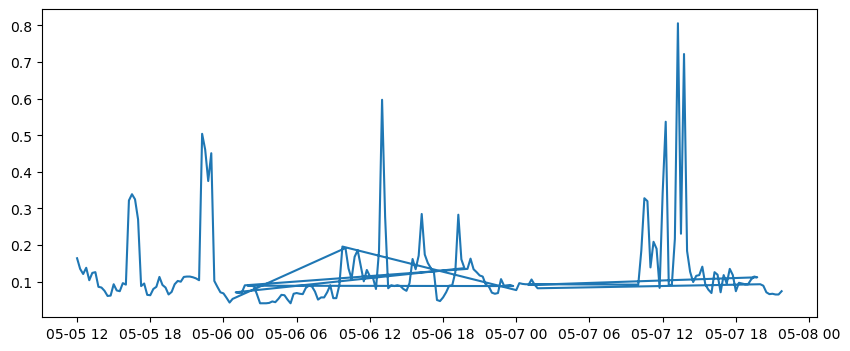

In [3]:
plt.figure(figsize=(10,4))
plt.plot(df.iloc[:200,0],df.iloc[:200,4])
plt.show()

In [4]:
undersample_data = df.loc[np.linspace(df.index.min(),df.index.max(),3000).astype(int)]
#undersample_time = df_index.loc[np.linspace(df_index.index.min(),df_index.index.max(),8784).astype(int)]
undersample_data = undersample_data.reset_index().drop('index',axis=1)
undersample_data

,Time,Energy_1,Energy_2,Energy_9,Energy_15,Energy_16,Energy_17,Energy_30,Energy_35,Energy_48,...,Energy_138,Energy_139,Energy_142,Energy_146,Energy_148,Energy_151,Energy_159,Energy_160,Energy_161,Energy_164
0,2022-05-05 12:00:00,0.068,0.018,0.024,0.164,0.072,0.055,0.006,0.080,0.062,...,0.052,0.083,0.084,0.0680,0.060,0.042,0.055,0.069,0.010,0.004
1,2022-05-05 15:00:00,0.096,0.018,0.024,0.093,0.072,0.064,0.006,0.068,0.062,...,0.052,0.086,0.004,0.0250,0.044,0.095,0.055,0.101,0.010,0.003
2,2022-05-05 18:15:00,0.036,0.018,0.024,0.080,0.074,0.086,0.006,0.045,0.062,...,0.052,0.060,0.004,0.0820,0.040,0.021,0.055,0.109,0.010,0.004
3,2022-05-05 21:30:00,0.121,0.018,0.024,0.112,0.003,0.170,0.006,0.044,0.062,...,0.052,0.051,0.004,0.1150,0.105,0.144,0.055,0.069,0.010,0.004
4,2022-05-06 00:30:00,0.082,0.018,0.024,0.043,0.003,0.038,0.006,0.044,0.062,...,0.052,0.054,0.004,0.0720,0.054,0.074,0.055,0.093,0.010,0.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2023-06-06 21:30:00,0.153,0.083,0.113,0.090,0.002,0.334,0.087,0.045,0.087,...,0.046,0.164,0.004,0.0945,0.064,0.143,0.125,0.117,0.000,0.003
2996,2023-06-06 02:30:00,0.029,0.035,0.039,0.066,0.002,0.047,0.010,0.044,0.080,...,0.046,0.076,0.004,0.0660,0.040,0.045,0.069,0.067,0.019,0.003
2997,2023-06-06 05:45:00,0.013,0.067,0.068,0.059,0.002,0.083,0.010,0.044,0.093,...,0.056,0.038,0.004,0.0880,0.015,0.058,0.047,0.047,0.029,0.003
2998,2023-06-06 09:00:00,0.029,0.080,0.101,0.137,0.070,0.086,0.058,0.175,0.099,...,0.066,0.033,0.004,0.1000,0.012,0.166,0.041,0.078,0.020,0.003


In [ ]:
plt.plot(undersample_data.Time,undersample_data["Energy_15"])
plt.xlabel('Time (year)',fontsize=20)
plt.ylabel('Temperature',fontsize=20)

In [5]:
scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
undersmpl = pd.DataFrame(scaler.fit_transform(undersample_data.drop('Time', axis=1)).reshape(3000,n_houses))

In [6]:
n_clusters = 16

In [ ]:
from tqdm import tqdm
data_array = np.array(undersmpl.T.values)
cities_list = undersmpl.T.index.tolist()
inertia_list = []
cluster_list = []
model_list = []
for c in tqdm(range(2, n_clusters + 1)):
    model = TimeSeriesKMeans(n_clusters=c, metric="euclidean", max_iter=10, n_init=3, dtw_inertia=True)
    model.fit(data_array)
    model_list.append(model)
    inertia_list.append(model.inertia_)
    cluster_list.append(model.labels_)

In [ ]:
plt.plot(range(2, n_clusters +1), inertia_list)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

In [ ]:
sourceFile = open("clusters_loureiro____.txt", 'w')

In [ ]:
print("Cluster List\n", file=sourceFile)
print(cluster_list, file=sourceFile)
print("Inertia List\n", file=sourceFile)
print(inertia_list, file=sourceFile)
print("Model List\n", file=sourceFile)
print(model_list, file=sourceFile)

In [ ]:
sourceFile.close()

In [ ]:
cluster_list

In [ ]:
# Executed with 1-hour intervals
#y = np.array([1, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#       0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
#       0, 0, 0, 0, 0, 0, 0])

In [7]:
x = undersample_data['Time']

In [8]:
y = np.array([5, 4, 0, 0, 1, 0, 4, 1, 0, 1, 3, 4, 7, 1, 4, 5, 1, 1, 6, 5, 5, 5, 4, 1, 6, 0, 1, 5, 0, 1, 4, 2, 1, 0, 1, 4, 5, 0, 6, 1])
cities_list = undersmpl.T.index.tolist()

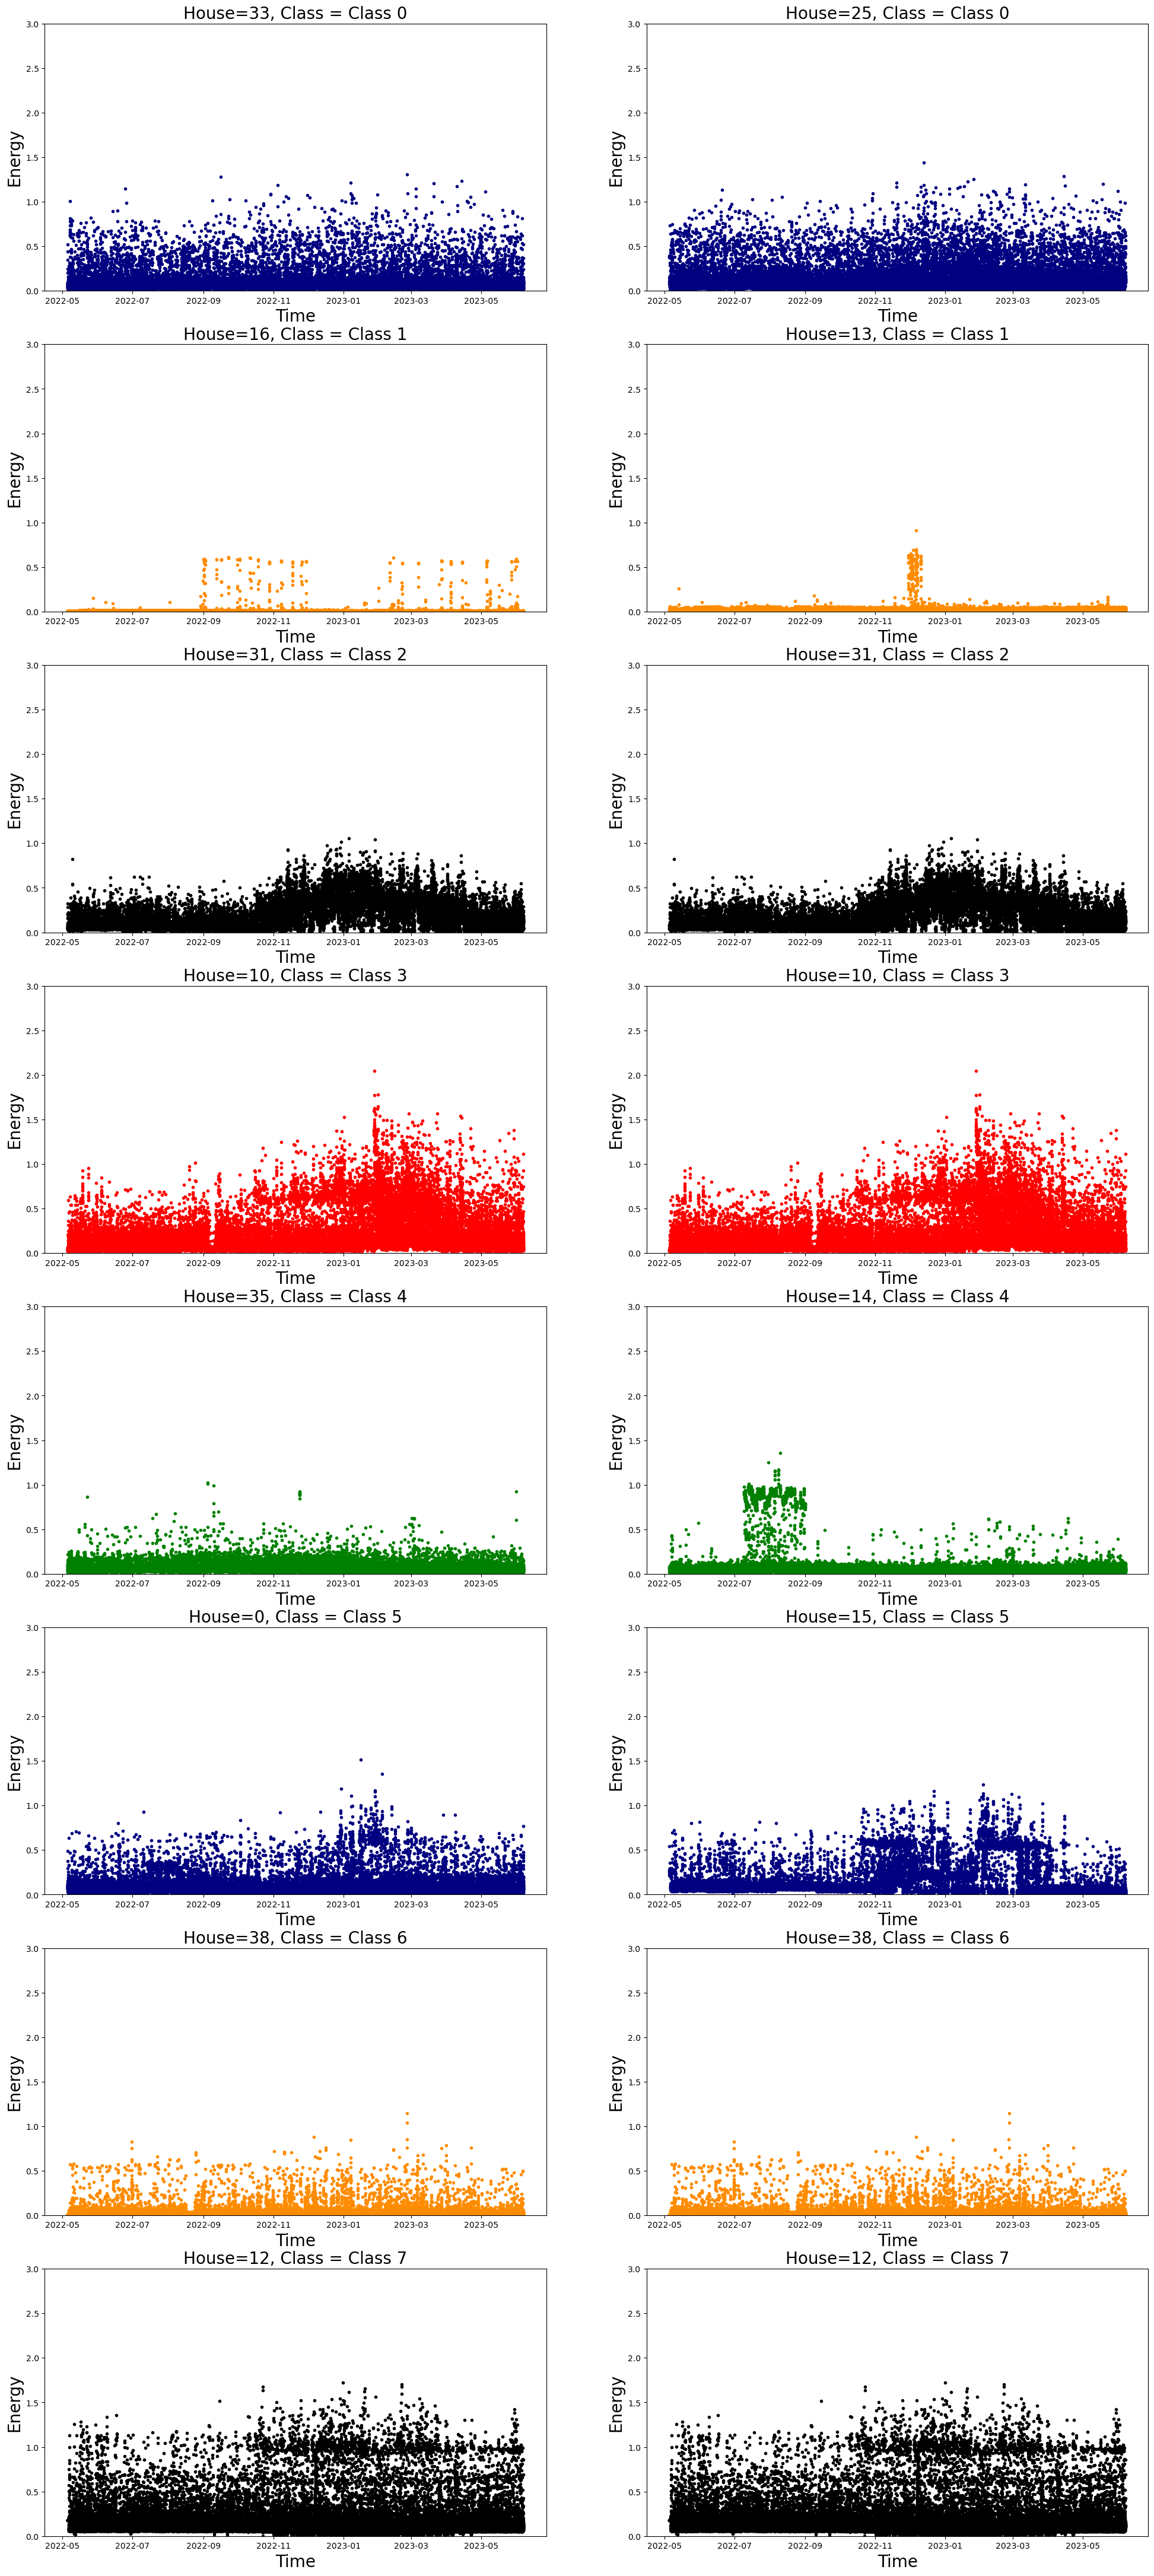

In [16]:
plt.figure(figsize=(24,55))
k_dict = {'1':0,'2':0,'3':1,'4':1,'5':2,'6':2,'7':3,'8':3,'9':4,'10':4, '11':5, '12':5, '13':6, '14':6, '15':7, '16':7}
colors = ['navy']*2+['darkorange']*2+['k']*2+['red']*2+['green']*2+['navy']*2+['darkorange']*2+['k']*2
Names = ['Class 0']*2+['Class 1']*2+['Class 2']*2+['Class 3']*2+['Class 4']*2+['Class 5']*2+['Class 6']*2+['Class 7']*2
for j in range(1,17):
    plt.subplot(8,2,j)
    k = np.random.choice(np.where(y==k_dict[str(j)])[0])
    plt.plot(df.Time,df["{}".format(df.drop('Time', axis=1).columns[k])],'.',color=colors[j-1])
    plt.ylabel('Energy',fontsize=20)
    plt.xlabel('Time',fontsize=20)
    plt.title('House=%s, Class = %s'%(cities_list[k],Names[j-1]),fontsize=20)
    plt.ylim(0,3)

In [ ]:
cluster_list = []
for i in range(0,n_clusters):
    cluster_list.append(np.where(y == i)[0])
len(cluster_list)

In [ ]:
string = "cluster"
for i in range(len(cluster_list)):
    st = string + str(i)
    locals()[st] = cluster_list[i]
    print(cluster_list[i])

In [ ]:
cluster0

In [ ]:
#cluster0.to_csv("data/.csv", index=None)

In [ ]:
#cluster2.to_csv("data/.csv", index=None)

In [ ]:
## Compare gains of cluster with normal runs